# Seasonal PageRank Trends
Plot first-order network PageRank seasonality so we can understand annual trends.

In [1]:
import matplotlib
#matplotlib.use('Agg')
import matplotlib.colors as mcolors
import matplotlib.patches as mpatches
import matplotlib.pyplot as plt
import networkx as nx
import numpy as np
import pandas as pd
import cartopy.crs as ccrs
import cartopy.io.shapereader as shpreader
import signac
from util import fetch_geodata, get_community

project = signac.get_project()
job = project.find_jobs({"year": 2011, "quarter": 1}).next()

In [2]:
def get_airport_id(iata):
    iatas = pd.read_csv(job.fn('airport_codes.csv')).set_index('ID')
    return iatas.index[iatas['IATA'] == iata][0]

In [3]:
def get_seasonal_pageranks(airport_id, query={}, mode='first_order'):
    pageranks = []
    years = []
    quarters = []
    for job in sorted(project.find_jobs(query), key=lambda job: (job.sp.year, job.sp.quarter)):
        fn = '{}_pagerank.txt'.format(mode)
        if job.isfile(fn):
            pageranks.append(pd.read_csv(
                job.fn(fn), header=None, names=['ID', 'PageRank']) \
                             .set_index('ID').loc[airport_id][0])
            years.append(job.sp.year)
            quarters.append(job.sp.quarter)
    dates = np.asarray(years) + (np.asarray(quarters)-1)*0.25
    return dates, pageranks

In [4]:
from matplotlib.ticker import MaxNLocator
from sklearn.preprocessing import scale

def plot_airport_pagerank(airports, query={}):
    plt.figure(figsize=(6, 4), dpi=400)
    for airport in airports:
        dates, pageranks = get_seasonal_pageranks(get_airport_id(airport), query)
        plt.plot(dates, scale(pageranks), label=airport)
        #plt.plot(dates, scale(pageranks), label=airport)
    #xs = np.arange(min(dates), max(dates), 0.25)
    #ys = np.cos(2 * np.pi * xs)
    #plt.plot(xs, scale(ys), label='cos(2*pi*year)')
    plt.title('PageRank Time Series')
    plt.legend()
    plt.ylabel('PageRank')
    plt.xlabel('Year')
    plt.gca().xaxis.set_major_locator(MaxNLocator(integer=True))
    plt.show()

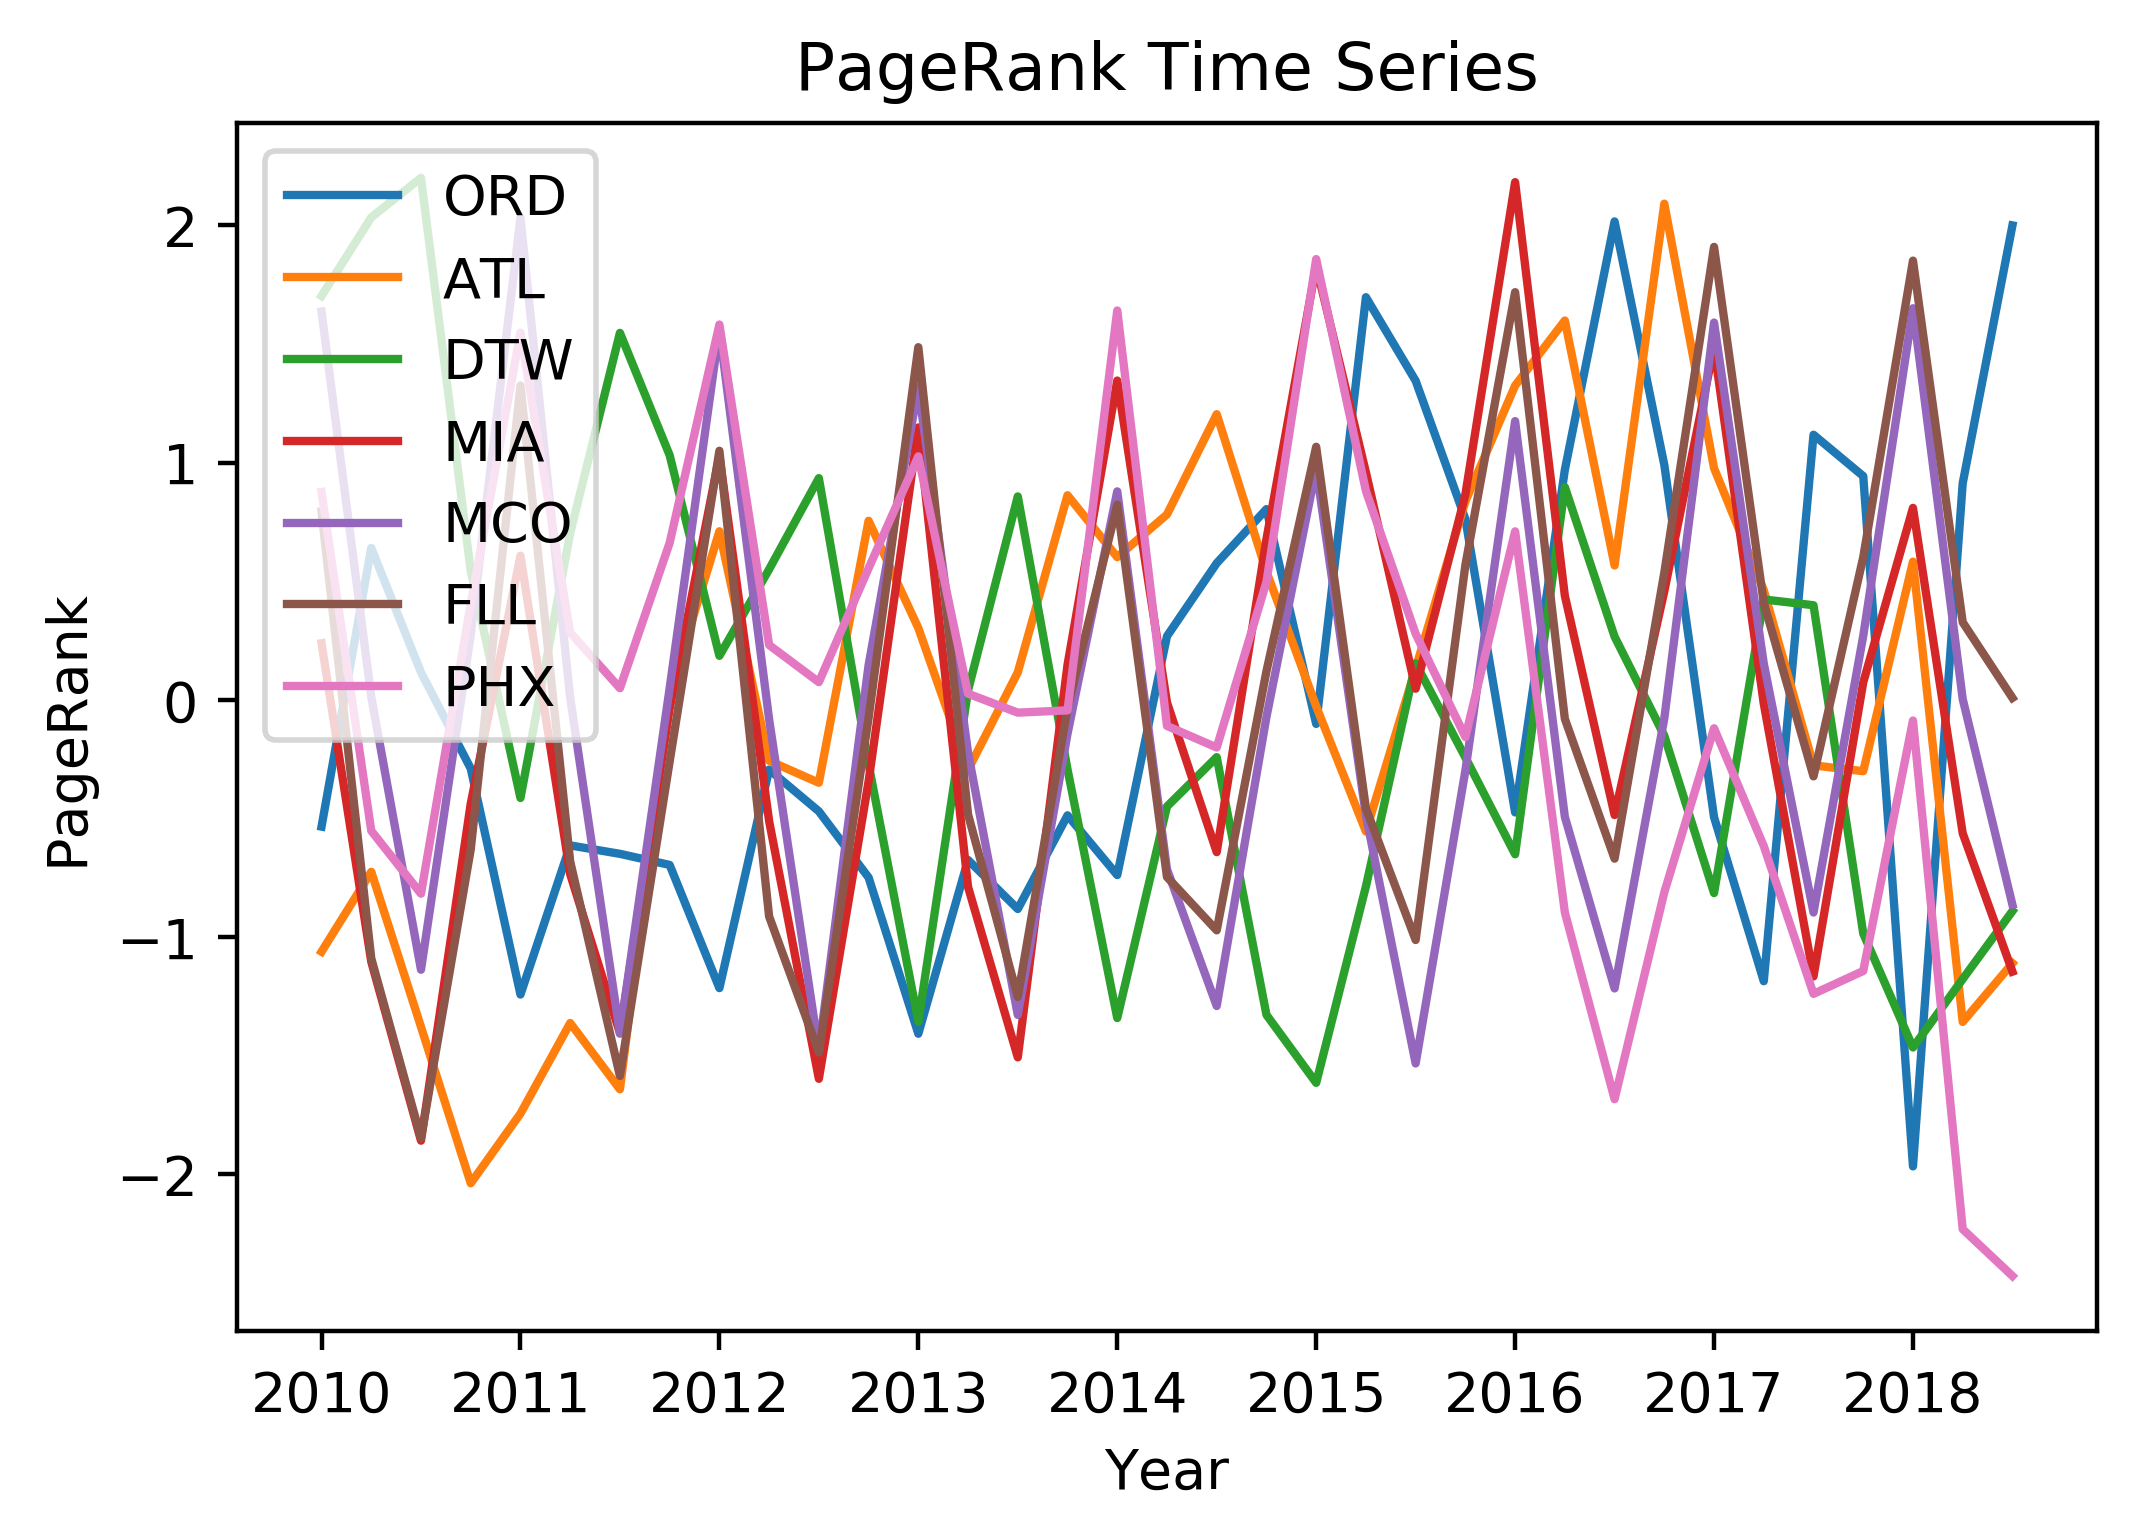

In [5]:
plot_airport_pagerank(['ORD', 'ATL', 'DTW', 'MIA', 'MCO', 'FLL', 'PHX'], query={'year.$gte': 2010})

# Interpretation
We can clearly see that some airports in the south are exhibiting a seasonal pattern; they are more active in Q1 than Q3. Next, we compute the correlation between each airport's first-order network PageRank and a sine wave that peaks in summer and troughs in winter. Positive correlation means high activity in summer, negative correlation means high activity in winter.

In [6]:
from functools import reduce
pageranks = []
for job in sorted(project, key=lambda job: (job.sp.year, job.sp.quarter)):
    df = pd.read_csv(job.fn('first_order_pagerank.txt'), header=None, names=['ID', 'PageRank'])
    df = df.set_index('ID')
    df.columns = ['{year}Q{quarter}'.format(**job.sp)]
    pageranks.append(df)
pageranks = reduce(lambda x, y: pd.merge(x, y, left_index=True, right_index=True, how='outer'), pageranks)
pageranks = pageranks.transpose().dropna(axis=1)

In [7]:
from scipy.signal import detrend
from util import fetch_geodata
correlations = {}
xs = np.arange(1993, 2018.75, 0.25)
ys = scale(-np.cos(2 * np.pi * xs))
for airport_id in pageranks.columns:
    data = scale(detrend(pageranks[airport_id]))
    correlations[airport_id] = np.corrcoef(ys, data)[0, 1]
correlations = pd.DataFrame.from_dict(correlations, orient='index', columns=['Seasonality'])
airport_codes = pd.read_csv(project.fn('airport_codes.csv')).set_index('ID')
correlations = pd.merge(correlations, airport_codes, left_index=True, right_index=True)
correlations = pd.merge(correlations, fetch_geodata(), left_on='IATA', right_index=True)
last_quarter_pageranks = pd.read_csv(
    project.find_jobs({'year': 2018, 'quarter': 3}).next().fn('first_order_pagerank.txt'),
    header=None, names=['ID', 'PageRank']
).set_index('ID')
correlations = correlations.merge(last_quarter_pageranks, left_index=True, right_index=True)

Reading airport geodata...


In [8]:
def plot_correlations(paths):
    print('Generating plot...')
    fig = plt.figure(figsize=(6, 4), dpi=400)
    ax = fig.add_axes([0, 0, 1, 1], projection=ccrs.LambertConformal())
    ax.set_extent([-128, -64, 22, 49], ccrs.Geodetic())

    shapename = 'admin_1_states_provinces_shp'
    states_shp = shpreader.natural_earth(resolution='110m',
                                         category='cultural', name=shapename)

    ax.background_patch.set_visible(False)
    ax.outline_patch.set_visible(False)
    plt.title('Airport PageRank Seasonality')

    def colorize_state(geometry):
        facecolor = (0.9375, 0.9375, 0.8594)
        return {'facecolor': facecolor, 'edgecolor': 'black'}

    ax.add_geometries(
        shpreader.Reader(states_shp).geometries(),
        ccrs.PlateCarree(),
        styler=colorize_state)

    xs = paths.lon.values
    ys = paths.lat.values
    colors = paths.Seasonality
    sizes = 10000*paths.PageRank.values
    dots = ax.scatter(xs, ys, transform=ccrs.PlateCarree(), c=colors, s=sizes,
                      alpha=0.8, zorder=10, cmap='seismic')

    top_n = paths.sort_values('PageRank', ascending=False).head(20).index
    for row in paths.loc[top_n].itertuples():
        ax.annotate(row.IATA, (row.lon, row.lat), xycoords=ccrs.PlateCarree()._as_mpl_transform(ax),
                    fontsize=30*row.PageRank**0.2,
                    zorder=11, ha='center', va='center')
    cbax = fig.add_axes([0.9, 0.1, 0.03, 0.8])
    cbar = plt.colorbar(dots, cax=cbax)
    cbar.ax.set_ylabel(r'Winter          $\bf{Active\ Season}$          Summer')
    plt.show()
    plt.close()

Generating plot...


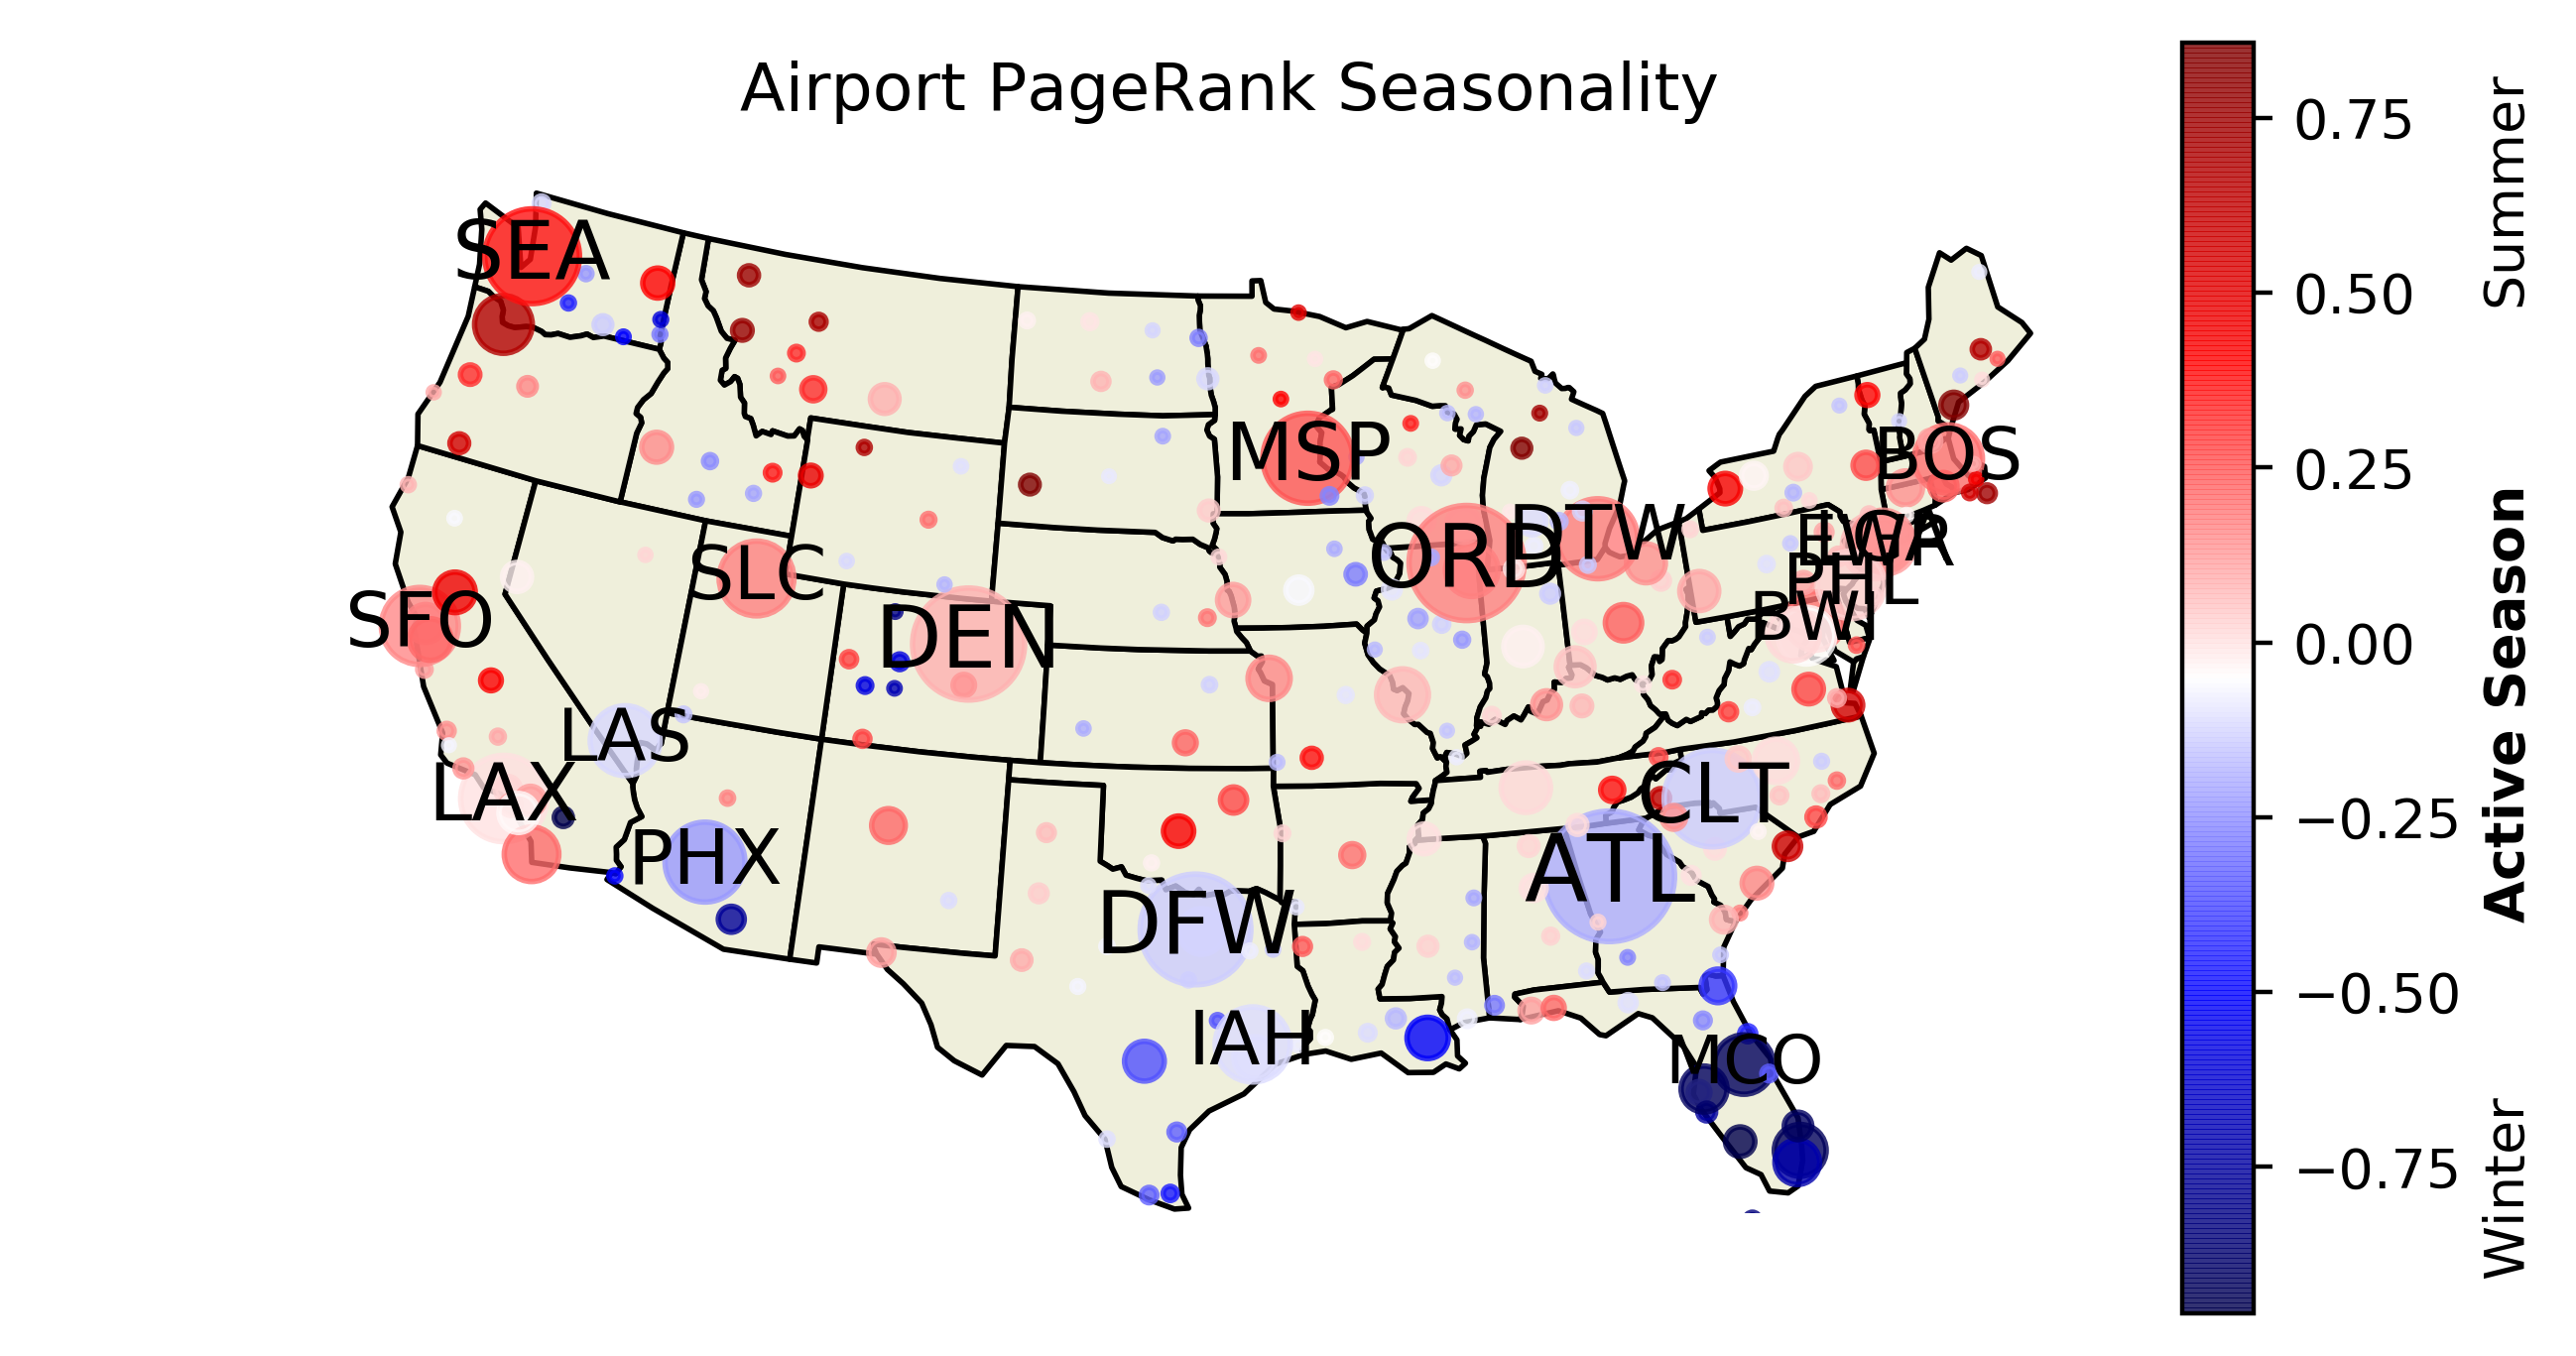

In [9]:
plot_correlations(correlations)